In this demo, we compute explanations for the ResNet-50 trained on ImageNet, where we define a grid of superpixels as features to perturb. The image below shows the grid superpixel segmentation. We consider each grid cell as a feature.
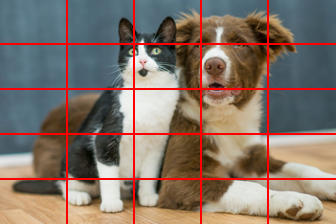
We first load required packages, the ResNet model and its preprocessing pipeline. Two classes are needed to compute the explanations. `BeamSearchExplainer` implements the beam search algorithm, and `*Masker` implements the feature masking. In this demo, we use `ImageGridMasker` since we need to mask out individual grid cells from an image input. The other demos showcase other `*Maskers`.

In [1]:
from solvex import BeamSearchExplainer, ImageGridMasker
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.models import resnet50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50(weights='IMAGENET1K_V2').to(device)
model.eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

The explainer expects the function to be explained in a particular format. Specifically, it takes in a list of `N` (full or masked) inputs, and returns a `numpy` array of shape `N x C` where `C` is the number of classes. The values of the array can be anything, but most commonly the class probability, which is what we are going to do here. In addition, when masking features (i.e., pixel grids) from an image, `ImageGridMasker` expects the image to be a `PIL.Image.Image` object and returns another such object. Thus, `imgs` is a list of `PIL.Image.Image` objects.

In [2]:
def model_func(imgs):
    imgs = torch.stack([preprocess(img) for img in imgs], dim=0).to(device)
    with torch.no_grad():
        logits = model(imgs)
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs

Next we prepare the input image and instantiate the explainer. `ImageGridMasker` takes two arguments. `resolution` specifies the grid resolution. In our case, we want a `5 x 5` grid. It can also be a 2-tuple `(r_h, r_w)`, for height and width resolutions. `fill_value` specifies the masking operation. In this case, we replace the pixel value with the average pixel value of the entire image. Other options include `'local_mean'` of the grid cell and fixed pixel values in the format of an `uint8` number `v` or an `uint8` 3-tuple `(r, g, b)`.

In [3]:
# download the image and resize to have shorter side length of 224 pixels
url = 'https://yilunzhou.github.io/solvability/cat_and_dog.jpg'
image = Image.open(BytesIO(requests.get(url).content))
ratio =  224 / min(image.size)
image = image.resize((np.array(image.size) * ratio).astype('int32'))

masker = ImageGridMasker(resolution=5, fill_value='global_mean')
explainer = BeamSearchExplainer(masker, f=model_func, beam_size=50, batch_size=50)

Now we are ready to explain! The image shows a dog and a cat, and we are interested in which pixels contribute the most to each label. Since there are multiple ImageNet classes for different dog and cat species, we choose the class with the highest predicted probability for each, which is class 232 (Border collie) for dog (15.9%) and class 285 (Egyptian cat) for cat (1.0%). We specify the target class via the `label` argument to `explain_instance`. If it is not provided, the label with the highest function value will be used.

In [4]:
e_dog = explainer.explain_instance(image, label=232)  # Border collie
e_cat = explainer.explain_instance(image, label=285)  # Egyptian cat

100%|█████████████████████████████████| 25/25 [00:26<00:00,  1.04s/it]


The explanation `e_dog`/`e_cat` we get is a dictionary of keys `'exp'`, `'label'` and `'func_val'`, of type `list`, `int` and `float` respectively, as printed out below.

In [5]:
print(e_dog)

{'exp': [7.5, 5.5, 13.5, 17.5, 8.5, 6.5, -6.5, -5.5, 10.5, 4.5, -1.5, -4.5, -2.5, 2.5, 11.5, 9.5, 1.5, -0.5, 3.5, 14.5, 12.5, 16.5, 0.5, -3.5, 15.5], 'label': 232, 'func_val': 0.15876223}


Even better, all built-in `*Masker` classes include more user-friendly explanation displays, and the `ImageGridMasker` class has two. They can be called with `masker.render_result`, using different `mode` parameters. The first one is console printing.

In [6]:
masker.render_result(image, e_dog, mode='text', execute=True)

Explained label: 232
Function value for label 232: 0.159
Grid cell feature attribution:
+------------+-----------+-----------+------------+
| Cell idx   | Row idx   | Col idx   |   Attr val |
|------------+-----------+-----------+------------|
| Cell 0     | row 0     | col 0     |        7.5 |
| Cell 1     | row 0     | col 1     |        5.5 |
| Cell 2     | row 0     | col 2     |       13.5 |
| Cell 3     | row 0     | col 3     |       17.5 |
| Cell 4     | row 0     | col 4     |        8.5 |
| Cell 5     | row 1     | col 0     |        6.5 |
| Cell 6     | row 1     | col 1     |       -6.5 |
| Cell 7     | row 1     | col 2     |       -5.5 |
| Cell 8     | row 1     | col 3     |       10.5 |
| Cell 9     | row 1     | col 4     |        4.5 |
| Cell 10    | row 2     | col 0     |       -1.5 |
| Cell 11    | row 2     | col 1     |       -4.5 |
| Cell 12    | row 2     | col 2     |       -2.5 |
| Cell 13    | row 2     | col 3     |        2.5 |
| Cell 14    | row 2     | c

The second one is color overlay on top of the input image (i.e., the typical saliency map visualization).

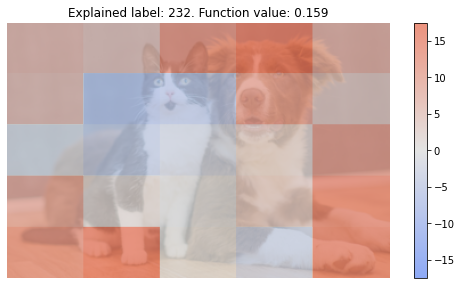

In [7]:
masker.render_result(image, e_dog, mode='color', execute=True)

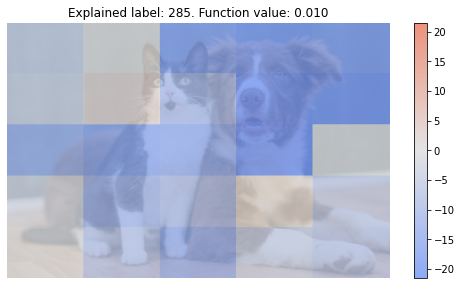

In [8]:
masker.render_result(image, e_cat, mode='color', execute=True)

For the dog class explanation, most grid cells on the dog have very positive influence (red colors), while those on the cat face have mildly negative influence (blue colors). Curiously, the cat feet grid cell has high positive influence -- probably the model confusing them as dog feet?

For the cat class explanation, grid cells on the dog have very negative influence, meaning that their removal would significantly increase predicted probability for the cat class. By comparison, none of the features have strong positive influence. This also makes sense: we define a feature to have high positive influence if its removal greatly decreases the predicted probability, but the current probability of 1.0% is already quite low!

And that's it! Want to learn more? Check out the other tabs for more use cases. If you want to gain a deeper understanding of the `*Masker` classes and implement your own, check out this jupyter notebook for an example where we build one from scratch and browse the documentations. Bugs? Suggestions? Questions? Ask away on [GitHub](https://github.com/YilunZhou/solvability-explainer)!